<h1>Pre-trained Transformer with Hugging Face</h1>

* 허깅 페이스를 이용한 트랜스포머 task 별 API

# Hugging face Transformer install
* https://huggingface.co/docs/transformers/v4.32.1/en/installation

In [1]:
!pip install transformers --proxy 70.10.15.10:8080


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# import, text

* API  pipeline : https://huggingface.co/docs/transformers/v4.32.1/en/main_classes/pipelines#transformers.pipeline
 * task : https://huggingface.co/docs/transformers/v4.32.1/en/main_classes/pipelines#transformers.pipeline.task

In [2]:
import os
os.environ["HTTP_PROXY"] = "http://70.10.15.10:8080"
os.environ['HTTPS_PROXY'] = "http://70.10.15.10:8080"
os.environ['CURL_CA_BUNDLE'] = ''
#os.environ['PYTHONHTTPSVERIFY'] ='0' 

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from transformers import pipeline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Text Classification
* download from  : https://huggingface.co/models?pipeline_tag=text-classification&sort=trending
* default classifier : https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english

## Pipeline 기본 모델

In [3]:
#classifier = pipeline("sentiment-analysis")
classifier = pipeline('text-classification') #, device=device)

classifier("I've been waiting for a HuggingFace course my whole life.")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9598049521446228}]

## 개별 API

In [4]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)

text = "I've been waiting for a HuggingFace course my whole life."
inputs = tokenizer(text, return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
label = model.config.id2label[predicted_class_id]
score = torch.softmax(logits, dim=1).squeeze()[predicted_class_id].item()
print(f'label:{label}, score:{score}')

label:POSITIVE, score:0.9598049521446228


## pipeline 모델 지정

In [8]:
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)
classifier("I've been waiting for a HuggingFace course my whole life.")

[{'label': 'POSITIVE', 'score': 0.9598049521446228}]

## 여러 문장 분류

In [9]:
classifier(
    ["I've been waiting for a HuggingFace course my whole life.",
     "I hate this so much!"]
)

[{'label': 'POSITIVE', 'score': 0.9598049521446228},
 {'label': 'NEGATIVE', 'score': 0.9994558691978455}]

## 한국어 감정분류 : https://huggingface.co/matthewburke/korean_sentiment

In [11]:
classifier_ko = pipeline('text-classification', model='matthewburke/korean_sentiment')
classifier_ko(
    ["그녀가 먼저 말을 걸어와서 나는 무척 기뻤다.",
     "듣기 싫어 죽겠네, 짜증나니까 그만 좀 닥쳐줄래"]
)

[{'label': 'LABEL_1', 'score': 0.9496678709983826},
 {'label': 'LABEL_0', 'score': 0.9464049339294434}]

# Zero-shot Classification

## 기본 모델

In [12]:
classifier = pipeline("zero-shot-classification")
classifier(
    "This is a course about the Transformers library",
    candidate_labels=["education", "politics", "business"],
)

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like facebook/bart-large-mnli is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

## 한국어 zero-shot 분류
* https://huggingface.co/MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7

In [13]:
model_name = 'MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7'
classifier_ko = pipeline("zero-shot-classification", model_name )
classifier_ko(
    "이 강좌는 트랜스포머 라이브러리에 대한 것입니다.",
    candidate_labels=["교육", "정치", "사업"],
)

{'sequence': '이 강좌는 트랜스포머 라이브러리에 대한 것입니다.',
 'labels': ['교육', '정치', '사업'],
 'scores': [0.698142409324646, 0.2844962477684021, 0.017361324280500412]}

In [14]:
classifier_ko(
    "이 소총의 유효사거리는 5km를 넘습니다.",
    candidate_labels=["예술", "정치", "군사"],
)

{'sequence': '이 소총의 유효사거리는 5km를 넘습니다.',
 'labels': ['군사', '정치', '예술'],
 'scores': [0.7075012922286987, 0.15997396409511566, 0.1325247436761856]}

In [15]:
classifier_ko(
    "선과 색의 조화가 탁월한 그 작품은 과거의 어느 작가의 그것과 닮아 있다.",
    candidate_labels=["예술", "정치", "군사"],
)

{'sequence': '선과 색의 조화가 탁월한 그 작품은 과거의 어느 작가의 그것과 닮아 있다.',
 'labels': ['예술', '군사', '정치'],
 'scores': [0.8367241621017456, 0.08361183851957321, 0.0796639546751976]}

# NER(Named Entity Recognition)

## NER 기본 모델

In [46]:
ner = pipeline("ner", grouped_entities=True)
outputs = ner("My name is Sylvain and I work at Hugging Face in Brooklyn.")
pd.DataFrame(outputs)

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-p

,entity_group,score,word,start,end
0,PER,0.998169,Sylvain,11,18
1,ORG,0.979602,Hugging Face,33,45
2,LOC,0.993211,Brooklyn,49,57


## 한국어 NER

In [50]:
ner = pipeline("ner", model='xlm-roberta-large-finetuned-conll03-english', grouped_entities=True)
outputs = ner("홍길동씨는 잠실에 있는 숨겨진 국가정보원 빌딩에서 일하고 있다.")
pd.DataFrame(outputs)

Some weights of the model checkpoint at xlm-roberta-large-finetuned-conll03-english were not used when initializing XLMRobertaForTokenClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:169: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(


,entity_group,score,word,start,end
0,PER,0.999991,홍길동,0,3
1,LOC,0.999872,잠실,6,8
2,ORG,0.999843,국가정보원,17,22


# QnA

## QnA 기본 모델

In [51]:
question_answerer = pipeline("question-answering")
question_answerer(
    question="Where do I work?",
    context="My name is Sylvain and I work at Hugging Face in Brooklyn",
)

No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'score': 0.6949767470359802, 'start': 33, 'end': 45, 'answer': 'Hugging Face'}

## QnA 한국어

In [53]:
question_answerer = pipeline("question-answering", model='timpal0l/mdeberta-v3-base-squad2')
question_answerer(
    question="홍길동은 어디에 있지?",
    context="홍길동씨는 잠실에 있는 숨겨진 국가정보원 빌딩에서 청소를 하며 살아 가고있다.",
)

{'score': 0.7171654105186462, 'start': 5, 'end': 9, 'answer': ' 잠실에'}

In [54]:
question_answerer(
    question="홍길동은 무얼하고 있지?",
    context="홍길동씨는 잠실에 있는 숨겨진 국가정보원 빌딩에서 청소를 하며 살아 가고있다.",
)

{'score': 0.5880146622657776, 'start': 27, 'end': 31, 'answer': ' 청소를'}

# Summeraizer

## 기본 모델

In [55]:
summarizer = pipeline("summarization")
summarizer(
    """
    America has changed dramatically during recent years. Not only has the number of
    graduates in traditional engineering disciplines such as mechanical, civil,
    electrical, chemical, and aeronautical engineering declined, but in most of
    the premier American universities engineering curricula now concentrate on
    and encourage largely the study of engineering science. As a result, there
    are declining offerings in engineering subjects dealing with infrastructure,
    the environment, and related issues, and greater concentration on high
    technology subjects, largely supporting increasingly complex scientific
    developments. While the latter is important, it should not be at the expense
    of more traditional engineering.

    Rapidly developing economies such as China and India, as well as other
    industrial countries in Europe and Asia, continue to encourage and advance
    the teaching of engineering. Both China and India, respectively, graduate
    six and eight times as many traditional engineers as does the United States.
    Other industrial countries at minimum maintain their output, while America
    suffers an increasingly serious decline in the number of engineering graduates
    and a lack of well-educated engineers.
"""
)

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'summary_text': ' The number of engineering graduates in the United States has declined in recent years . China and India graduate six and eight times as many traditional engineers as the U.S. does . Rapidly developing economies such as China continue to encourage and advance the teaching of engineering . There are declining offerings in engineering subjects dealing with infrastructure, infrastructure, the environment, and related issues .'}]

## 한국어

In [56]:
summarizer = pipeline("summarization", model='ainize/kobart-news')
summarizer(
'''
    국내 전반적인 경기침체로 상가 건물주의 수익도 전국적인 감소세를 보이고 있는 것으로 나타났다.
    수익형 부동산 연구개발기업 상가정보연구소는 한국감정원 통계를 분석한 결과 전국 중대형 상가
    순영업소득(부동산에서 발생하는 임대수입, 기타수입에서 제반 경비를 공제한 순소득)이 1분기 ㎡당 3만4200원에서
    3분기 2만5800원으로 감소했다고 17일 밝혔다. 수도권, 세종시, 지방광역시에서 순영업소득이
    가장 많이 감소한 지역은 3분기 1만3100원을 기록한 울산으로, 1분기 1만9100원 대비 31.4% 감소했다.
    이어 대구(-27.7%), 서울(-26.9%), 광주(-24.9%), 부산(-23.5%), 세종(-23.4%), 대전(-21%),
    경기(-19.2%), 인천(-18.5%) 순으로 감소했다. 지방 도시의 경우도 비슷했다.
    경남의 3분기 순영업소득은 1만2800원으로 1분기 1만7400원 대비 26.4% 감소했으며
    제주(-25.1%), 경북(-24.1%), 충남(-20.9%), 강원(-20.9%), 전남(-20.1%), 전북(-17%),
    충북(-15.3%) 등도 감소세를 보였다. 조현택 상가정보연구소 연구원은 "올해 내수 경기의
    침체된 분위기가 유지되며 상가, 오피스 등을 비롯한 수익형 부동산 시장의 분위기도 경직된
    모습을 보였고 오피스텔, 지식산업센터 등의 수익형 부동산 공급도 증가해 공실의 위험도 늘었다"며
    "실제 올 3분기 전국 중대형 상가 공실률은 11.5%를 기록하며 1분기 11.3% 대비 0.2% 포인트
    증가했다"고 말했다. 그는 "최근 소셜커머스(SNS를 통한 전자상거래), 음식 배달 중개 애플리케이션,
     중고 물품 거래 애플리케이션 등의 사용 증가로 오프라인 매장에 영향을 미쳤다"며 "향후 지역,
      콘텐츠에 따른 상권 양극화 현상은 심화될 것으로 보인다"고 덧붙였다.
'''
)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


[{'summary_text': '수익형 부동산 연구개발기업 상가정보연구소는 한국감정원 통계를 분석한 결과 전국 중대형 상가 \n     순영업소득이 1분기 m2당 3만4200원에서 3분기 2만5800원으로 감소했다고 17일 밝혔으며 이는 국내 전반적인 경기침체로 상가 건물주의 수익도 전국적인 감소세를 보이고 있는 것으로 국내 내수 경기의 침체된 분위기가 유지되며 수익형 부동산 시장의 분위기도 경직된 모습을 보였고 수익형 부동산 공급도 증가해 공실의 위험도 늘었다고 밝혔다.'}]

# Translator

## 기본 모델

In [58]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.6 MB/s eta 0:00:00


In [2]:
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en")
translator("Ce cours est produit par Hugging Face.")

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


[{'translation_text': 'This course is produced by Hugging Face.'}]

## 한국어 - 영어

In [6]:

translator = pipeline("translation", model="Helsinki-NLP/opus-mt-ko-en")
translator("그는 서울에 있는 작은 빌딩에서 청소일을 하고 있다.")

[{'translation_text': "He's doing cleaning work in a small building in Seoul."}]

# Fill Mask

## 기본 모델

In [17]:
from transformers import pipeline

unmasker = pipeline("fill-mask")
unmasker("This course will teach you all about <mask> models.", top_k=5)

No model was supplied, defaulted to distilroberta-base and revision ec58a5b (https://huggingface.co/distilroberta-base).
Using a pipeline without specifying a model name and revision in production is not recommended.


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.19619670510292053,
  'token': 30412,
  'token_str': ' mathematical',
  'sequence': 'This course will teach you all about mathematical models.'},
 {'score': 0.04052688181400299,
  'token': 38163,
  'token_str': ' computational',
  'sequence': 'This course will teach you all about computational models.'},
 {'score': 0.03301766887307167,
  'token': 27930,
  'token_str': ' predictive',
  'sequence': 'This course will teach you all about predictive models.'},
 {'score': 0.03194142132997513,
  'token': 745,
  'token_str': ' building',
  'sequence': 'This course will teach you all about building models.'},
 {'score': 0.024522729218006134,
  'token': 3034,
  'token_str': ' computer',
  'sequence': 'This course will teach you all about computer models.'}]

## 한국어

In [47]:
unmasker = pipeline("fill-mask", model='klue/bert-base')
unmasker("아프면 [MASK]에 가야지 그렇게 있으면 어떡해.")

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.5734339952468872,
  'token': 4054,
  'token_str': '병원',
  'sequence': '아프면 병원 에 가야지 그렇게 있으면 어떡해.'},
 {'score': 0.1281987428665161,
  'token': 15873,
  'token_str': '응급실',
  'sequence': '아프면 응급실 에 가야지 그렇게 있으면 어떡해.'},
 {'score': 0.051282696425914764,
  'token': 1589,
  'token_str': '집',
  'sequence': '아프면 집 에 가야지 그렇게 있으면 어떡해.'},
 {'score': 0.015710914507508278,
  'token': 11082,
  'token_str': '치과',
  'sequence': '아프면 치과 에 가야지 그렇게 있으면 어떡해.'},
 {'score': 0.008946791291236877,
  'token': 28783,
  'token_str': '정형외과',
  'sequence': '아프면 정형외과 에 가야지 그렇게 있으면 어떡해.'}]

# GPT
* Generative Pre-trained Transformer
* OpenAI에서 발표한 Decoder 기반의 Pre-trained LM
* 비지도(자기지도) 사전 학습과 Fine-Tuning 지도 학습
* 다양한 NLP Task 지원을 위한 Special Tokens
    * Start, Extract, Delimiter 등
* In-context learning (GPT-2, GPT-3)
* Byte Pair Encoding (BPE), Positional Embedding
* 학습 데이터
  * BooksCorpus, 1B Word Benchmark 등 여러 Task를 지원하기 위한 다양한 dataset 학습
  * GPT 버전에 따라 사용하는 dataset이 다름 (GPT-3는 매우 방대한 데이터 사용)
* 학습 방법
  * 입력 Sequence의 다음 값을 예측하는 단순한 구조로 자기지도학습 수행
  * Meta-Learning (In-Context Learning)
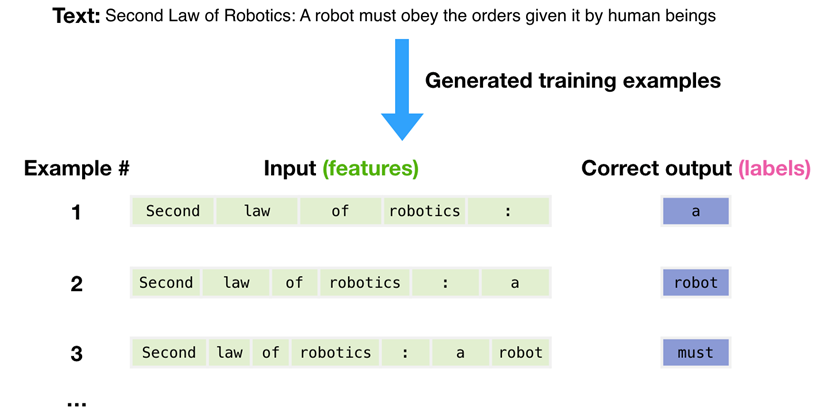

## Text Generator, GPT2

### 기본 모델

In [44]:
from transformers import pipeline

generator = pipeline("text-generation", model='gpt2')
generator("In this course, we will teach you how to")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'In this course, we will teach you how to get started in managing your personal finances. A lot of you may know what that means, but it is an incredibly important thing. This course is meant to explain how to manage your personal finances so as'}]

### 한국어 생성 모델

In [43]:
generator = pipeline("text-generation", model='skt/kogpt2-base-v2')
output = generator("감기에 걸리지 않으려면")
print(output[0]['generated_text'])

감기에 걸리지 않으려면 외출 후 양치질을 하거나 젖은 옷을 입히고 옷을 자주 건조하는 것이 좋은데요.
아무래도 아드레날린이 분비되는 피부와 피부가 만나면 피부가 민감해지기 때문입니다.
피부는 햇빛에 의한 자극에 노출되면 더욱 예민


## GPT2 한국어 챗봇

### 한국어 챗봇 데이터
* https://github.com/songys/Chatbot_data
  * 챗봇 트레이닝용 문답 페어 11,876개
  * label : 일상다반사:0, 이별(부정):1, 사랑(긍정):2

In [37]:
url = "https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv"
df = pd.read_csv(url)

df = df[:1000] # 빠른 실험을 위해서
print(df['label'].value_counts())
print(df.shape)
df.head()


0    1000
Name: label, dtype: int64
(1000, 3)


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [38]:
import re
from transformers import PreTrainedTokenizerFast
from torch.utils.data import DataLoader, Dataset

Q_TKN = "<usr>"
A_TKN = "<sys>"
BOS = '<s>'
EOS = '</s>'
MASK = '<unused0>'
SENT = '<unused1>'
PAD = '<pad>'

koGPT2_TOKENIZER = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
                                                           bos_token=BOS,
                                                           eos_token=EOS,
                                                           unk_token="<unk>",
                                                           pad_token=PAD,
                                                           mask_token=MASK)


class ChatbotDataset(Dataset):
    def __init__(self, chats, max_len=40):
        self._data = chats
        self.max_len = max_len
        self.q_token = Q_TKN
        self.a_token = A_TKN
        self.sent_token = SENT
        self.eos = EOS
        self.mask = MASK
        self.tokenizer = koGPT2_TOKENIZER

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        turn = self._data.iloc[idx]
        q = turn["Q"]
        q = re.sub(r"([?.!,])", r" ", q)
        a = turn["A"]
        a = re.sub(r"([?.!,])", r" ", a)
        q_toked = self.tokenizer.tokenize(self.q_token + q) #+ self.sent_token)
        q_len = len(q_toked)
        a_toked = self.tokenizer.tokenize(self.a_token + a + self.eos)
        a_len = len(a_toked)

        #질문길이가 최대길이보다 크면
        if q_len > self.max_len:
            a_len = self.max_len - q_len     #답변의 길이 = 최대길이 - 질문길이
            if a_len <= 0:       #질문길이가 최대길이를 초과 하면
                q_toked = q_toked[-(int(self.max_len / 2)) :] #질문길이= 최대길이/2
                q_len = len(q_toked)
                a_len = self.max_len - q_len     #답변길이= 최대길이 - 질문길이
            a_toked = a_toked[:a_len]
            a_len = len(a_toked)

        #질문길이 + 답변길이가 최대길이보다 크면
        if q_len + a_len > self.max_len:
            a_len = self.max_len - q_len        #답변길이= 최대길이 - 질문길이
            if a_len <= 0:       #질문길이가 최대길이를 초과 하면
                q_toked = q_toked[-(int(self.max_len / 2)) :]   #질문길이=최대길이/2
                q_len = len(q_toked)
                a_len = self.max_len - q_len       #답변길이= 최대길이 - 질문길이
            a_toked = a_toked[:a_len]
            a_len = len(a_toked)

        labels = [self.mask,] * q_len + a_toked[1:]
        mask = [0] * q_len + [1] * a_len + [0] * (self.max_len - q_len - a_len)
        labels_ids = self.tokenizer.convert_tokens_to_ids(labels)
        # PADDING
        while len(labels_ids) < self.max_len:
            labels_ids += [self.tokenizer.pad_token_id]

        token_ids = self.tokenizer.convert_tokens_to_ids(q_toked + a_toked)
        # PADDING
        while len(token_ids) < self.max_len:
            token_ids += [self.tokenizer.pad_token_id]

        return (np.array(token_ids), np.array(mask), np.array(labels_ids))


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [39]:
koGPT2_TOKENIZER.convert_tokens_to_ids([Q_TKN, A_TKN, MASK, PAD, EOS, SENT])

[2, 4, 9, 3, 1, 10]

In [40]:
train_set = ChatbotDataset(df, max_len=40)

for sample in train_set:
  token_id, mask, label_id = sample
  print(token_id.shape, mask.shape, label_id.shape)
  print('token:', token_id)
  print('label:', label_id)
  print('mask:', mask)
  break


(40,) (40,) (40,)
token: [    2  9349  7888   739  7318   739     4 12557  6824  9108  9028  7098
  8084   739     1     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3]
label: [    9     9     9     9     9     9 12557  6824  9108  9028  7098  8084
   739     1     3     3     3     3     3     3     3     3     3     3
     3     3     3     3     3     3     3     3     3     3     3     3
     3     3     3     3]
mask: [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


In [41]:
def collate_batch(batch):
    data = [item[0] for item in batch]
    mask = [item[1] for item in batch]
    label = [item[2] for item in batch]
    return torch.LongTensor(data), torch.LongTensor(mask), torch.LongTensor(label)

train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_batch,)

### Model 생성


### 모델 학습

In [42]:
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2').to(device)
criterion = torch.nn.CrossEntropyLoss(reduction="none")
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
epoch = 10
Sneg = -1e18
model.train()
for epoch in range(epoch):
    cost =0
    n_batch = len(train_dataloader)
    for batch_idx, samples in enumerate(train_dataloader):
        optimizer.zero_grad()
        token_ids, mask, label = samples
        token_ids, mask, label = token_ids.to(device), mask.to(device), label.to(device)
        out = model(token_ids)
        out = out.logits
        mask_3d = mask.unsqueeze(dim=2).repeat_interleave(repeats=out.shape[2], dim=2)
        mask_out = torch.where(mask_3d == 1, out, Sneg * torch.ones_like(out))
        loss = criterion(mask_out.transpose(2, 1), label)
        avg_loss = loss.sum() / mask.sum()
        avg_loss.backward()
        optimizer.step()
        cost += avg_loss/n_batch
    print(f'epoch={epoch}, loss:{cost}')

epoch=0, loss:35.743350982666016
epoch=1, loss:34.40928649902344
epoch=2, loss:33.6923713684082
epoch=3, loss:33.64809799194336
epoch=4, loss:33.342403411865234
epoch=5, loss:33.28986358642578
epoch=6, loss:32.94298553466797
epoch=7, loss:32.92020797729492
epoch=8, loss:33.01490020751953
epoch=9, loss:32.8513298034668


### 챗봇 실행

In [43]:
with torch.no_grad():
    while 1:
        q = input("user > ").strip()
        if q == "quit":
            break
        a = ""
        while 1:
            input_ids = torch.LongTensor(koGPT2_TOKENIZER.encode(Q_TKN + q + A_TKN + a)).unsqueeze(dim=0).to(device)
            pred = model(input_ids)
            pred = pred.logits
            gen = koGPT2_TOKENIZER.convert_ids_to_tokens(torch.argmax(pred, dim=-1).squeeze().cpu().numpy().tolist())[-1]
            if gen == EOS:
                break
            a += gen.replace("▁", " ")
        print("Chatbot > {}".format(a.strip()))


user > 점심 뭐 먹지
Chatbot > 뭐라도 드세요
user > 좀 피곤하네
Chatbot > 잠깐 바람 쐬고 오세요
user > 머리가 아파
Chatbot > 자책하지 마세요
user > 퇴근 하고 뭐하지
Chatbot > 뭐하고 있나요
user > 살을 좀 빼야 겠어
Chatbot > 적게 먹고 많이 움직이세요
user > 잘있어
Chatbot > 잘 해결되길 바라요
user > quit


# BERT
* Bidirectional Encoder Representations from Transformers (BERT)
* Google AI Language에서 발표한 Encoder 기반의 사전 학습된 모델
* 양방향 정보를 참고하는 언어 모델로 이를 위한 학습 방법 제안
* 비지도(자기지도) 사전 학습과 Fine-Tuning 지도 학습
* 다양한 NLP Task 및 학습을 위한 Special Tokens
* Bidirectional Encoder Representations from Transformers (BERT)
  * Masked LM: 입력 Token 중 일부를 임의로 Masking 후 해당 Token 예측
  * 양방향 정보를 인식하기 위한 학습 방법

> ```<CLS> 음바페 선수는 월드컵 결승에서 많은 골을 넣었다. <SEP>```
```연장 후반에 세 번째 골을 넣으며 해트트릭을 달성하였다.<SEP>```

> ```<CLS> 음바페 <MASK>는 월드컵 <MASK>에서 많은 <MASK>을 넣었다. <SEP>```
```연장 <MASK>에 세 번째 골을 넣으며 <MASK>을 달성하였다.<SEP>```

* Pre-Training과 Fine-Tuning의 Task 종류에 따라 Mismatch 발생
  * Masking 대상 중 일부는 정답, 일부는 임의, 나머지는 Masking 처리
  * 논문에서는 15%의 대상 중 80% Masking, 10%는 임의 Token, 나머지는 정답

> ```<CLS> 음바페 친구는 월드컵 <MASK>에서 많은 <MASK>을 넣었다. <SEP>```
```연장 <MASK>에 세 번째 골을 넣으며 해트트릭을 달성하였다.<SEP>```
  * `친구` : 임의(20%)
  * `<MASK>` : Masking(60%)
  * `해트트릭` : 정답(20%)

* Next Sentence Prediction (NSP): 두 문장 간의 관계 파악 학습
  * <SEP> 토큰으로 문장의 끝을 구분
  * 두 문장이 이어지는 문장인지 여부를 <CLS>를 통해 분류
  * Label은 isNext or notNext


## BERT Tokenizer
* https://huggingface.co/docs/transformers/v4.32.1/en/model_doc/bert
* Embeddings in BERT
  * Token Embedding: WordPiece Embedding 처리된 입력 Sequence
  * Sub-word Tokenizer: 자주 등장하지 않는 단어는 더 작은 단위로 분할하는 방법
  * 단어 집합에 없는 토큰은 분할하며, 이 때 분할된 조각에는 ## 추가
  * OOV 발생 빈도를 줄일 수 있는 장점


### 영어

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(tokenizer.tokenize('I love ham and cheese'))
print(tokenizer.tokenize('Subword embedding test'))

['i', 'love', 'ham', 'and', 'cheese']
['sub', '##word', 'em', '##bed', '##ding', 'test']


### 한국어

In [44]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
print(tokenizer.tokenize('나는 하몽과 치즈를 좋아한다.'))

['나', '##는', '하', '##몽', '##과', '치즈', '##를', '좋아한다', '.']


## BERT Fine tuning
* 한국어 Fill Mask 모델을 이용한 영화 리뷰 감성 분류

### Fill Mask 모델로 문장 분류 실험
* 당연하게도 추론 성능이 매우 나쁘다.

In [46]:
from transformers import pipeline

texts = ['아름다운 밥이에요.', '아 짜증나 듣기 싫어 죽겠네.']
model_name = 'klue/bert-base' # Fill Mask, 나쁜 성능
#model_name = 'Woonn/klue_bert_base' #fine-tuned classifier for sequence classification, 좋은 성능

classifier = pipeline('text-classification', model=model_name )
classifier(texts)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'label': 'LABEL_0', 'score': 0.6150811910629272},
 {'label': 'LABEL_0', 'score': 0.6272961497306824}]

### 한국어 감정 분류 데이터

In [55]:
import pandas as pd
import numpy as np
url_train = 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
url_test = "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt"

train_data = pd.read_table(url_train)
test_data = pd.read_table(url_test)
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [56]:
# 중복 제거
train_data = train_data.drop_duplicates(subset=['document'])
test_data = test_data.drop_duplicates(subset=['document'])
# 한글만 남기고 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
# 공백을 빈 문자열로 변경
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True)
test_data['document'] = train_data['document'].str.replace('^ +', "", regex=True)
# 빈 문자열을 결측치로 변경
train_data['document'] = train_data['document'].replace('', np.nan)
test_data['document'] = test_data['document'].replace('', np.nan)
# 결측치 제거
train_data = train_data.dropna()
test_data = test_data.dropna()

In [57]:
from transformers import AutoTokenizer

def tokenize(tokenizer, sentences):
    input_ids = []
    attention_mask = []

    for sentence in sentences:
        ret = tokenizer.encode_plus(
            sentence,
            max_length=20,              # 최대 토큰 수
            add_special_tokens=True,
            padding='max_length',       # padding
            return_attention_mask=True, # attention_mask 추출
            truncation=True
        )
        input_ids.append(ret['input_ids'])
        attention_mask.append(ret['attention_mask'])
    input_ids = torch.LongTensor(input_ids)
    attention_mask = torch.LongTensor(attention_mask)
    return input_ids, attention_mask

tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

# 학습 10000개, 평가 1000개
train_ids, train_masks = tokenize(tokenizer, train_data.document[:10000].values)
test_ids, test_masks = tokenize(tokenizer, train_data.document[10000:11000].values)

### 사전 훈련 모델로 추론 및 평가
* 매우 낮은 성능

In [59]:
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score

model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base')
y_test_pred = model(test_ids, attention_mask=test_masks)
test_acc = accuracy_score(train_data.label[10000:11000].values,
                          y_test_pred[0].detach().numpy().argmax(axis=1))
test_acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.608

### Dataset, DataLoader

In [63]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, ids, masks, labels):
        self.ids = ids
        self.masks = masks
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.ids[idx], self.masks[idx], self.labels[idx]

train_set = CustomDataset(train_ids,
                          train_masks, train_data.label[:10000].values)
test_set = CustomDataset(test_ids,
                         test_masks, train_data.label[10000:11000].values)

In [64]:
from torch.utils.data import DataLoader

SEED = 777
torch.manual_seed(SEED)

train_loader = DataLoader(dataset=train_set, batch_size=32,
                          shuffle=True, drop_last=True)

valid_loader = DataLoader(dataset=test_set, batch_size=32)

### AutoModelForSequenceClassification Fine Tuning

In [65]:
from tqdm import tqdm
from torch.nn import functional as F
from transformers import AutoModelForSequenceClassification
from torch import optim
import torch.nn as nn

model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base').to(device)
loss = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, eps=1e-7)

n_epochs = 5 # epochs 수
results = {'Loss':[], 'Val_Loss':[]}
pbar = tqdm(range(n_epochs))
for epoch in pbar:
    train_loss = 0
    valid_loss = 0
    n_train_batches = len(train_loader)
    n_valid_batches = len(valid_loader)
    model.train() # 학습 모드
    for ids, mask, y in train_loader:
        ids, mask, y = ids.to(device), mask.to(device), y.to(device)
        h = model(ids, mask) # 예측 값 생성
        cost = loss(F.softmax(h[0], dim=1)[:, 1:], y.view(-1, 1)) # cost 계산
        optimizer.zero_grad() # 기울기 초기화
        cost.backward()       # 역전파 수행
        optimizer.step()      # 기울기 업데이트
        train_loss += cost/n_train_batches
    pbar.set_postfix(epoch=f'{epoch:2d}', loss=f'{train_loss.item():9.5f}')
    results['Loss'].append(train_loss.item())

    model.eval()
    with torch.no_grad():
        for ids, mask, y in valid_loader:
            ids, mask, y = ids.to(device), mask.to(device), y.to(device)
            h = model(ids, mask) # 예측 값 생성
            cost = loss(F.softmax(h[0], dim=1)[:, 1:], y.view(-1, 1)) # cost 계산
            valid_loss += cost/n_valid_batches
        pbar.set_postfix(epoch=f'{epoch:2d}',
                         loss=f'{train_loss.item():9.5f}', val_loss=f'{valid_loss.item():9.5f}')
        results['Val_Loss'].append(valid_loss.item())

100%|██████████| 5/5 [03:37<00:00, 43.57s/it, epoch=4, loss=0.09028, val_loss=0.62289]


In [66]:
from sklearn.metrics import accuracy_score

model.eval()
with torch.no_grad():
    y_test_pred = model(test_ids.to(device), test_masks.to(device))
    test_acc = accuracy_score(
        train_data.label[10000:11000].values,
        F.softmax(y_test_pred[0], dim=1).argmax(dim=1).view(-1).detach().cpu().numpy())
test_acc

0.816

In [67]:
# Pipeline으로 추론하기
texts = ['아름다운 밥이에요.', '아 짜증나 듣기 싫어 죽겠네.']
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer, device=device)
classifier(texts)

[{'label': 'LABEL_1', 'score': 0.9843644499778748},
 {'label': 'LABEL_0', 'score': 0.9984304308891296}]